# Multi-Period Inventory Model

## Initial Calculations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter, get_distributions

### Select sku

In [ ]:
all_skus = pd.read_csv('online_retail2.csv')
all_skus = all_skus[all_skus.Quantity > 0]
all_skus = all_skus[all_skus.Price > 0]
all_skus.dropna(inplace= True)
all_skus.drop_duplicates(inplace=True)
sku = all_skus[all_skus.StockCode == '85099B']

sku = sku[['Quantity', 'InvoiceDate']].copy().reset_index(drop=True)
sku.InvoiceDate = pd.to_datetime(sku.InvoiceDate)
sku['Year'] = sku.InvoiceDate.dt.year.astype('str')
sku['Week'] = sku.InvoiceDate.dt.isocalendar().week.astype('str')
sku.Week = [i if len(i)>1 else '0'+i for i in sku.Week]
sku['time_unit'] = sku.Year + '-' + sku.Week
# sku.sample(10)

In [ ]:
grp = sku.groupby('time_unit').Quantity.sum().reset_index()
# grp

### Finding and eliminating outliers

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=grp,x='Quantity');

In [ ]:
grp = grp[grp.Quantity<2000].copy()
plt.figure(figsize=(12,6))
sns.boxplot(data=grp,x='Quantity');

### Find the best fitted distribution

In [ ]:
plt.figure(figsize=(12,6)) 
demand_week = grp['Quantity'].values
plt.figure(figsize=(12,6))
f = Fitter(data=demand_week,
           distributions=['lognorm',
                          'norm',
                          'triang',
                          'gamma',
                          'uniform',
                          'expon',
                          'rayleigh']
           )
f.fit()
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error')

In [ ]:
print(f.fitted_param['norm'])
print(f.fitted_param['gamma'])

In [ ]:
from scipy.stats import norm, gamma
normal_dist = norm(f.fitted_param['norm'][0],f.fitted_param['norm'][1])
gamma_dist = gamma(f.fitted_param['gamma'][0],f.fitted_param['gamma'][1],f.fitted_param['gamma'][2])

In [ ]:
mean_demand = gamma_dist.mean()
std_demand = gamma_dist.std()
print(mean_demand)
print(std_demand)

## 1. EOQ Method

Parameters
* Lead time is 2 weeks
* Excess cost is 5 dollors per unit per week
* Shortage cost is 25 dollors per unit per week

In [ ]:
D = mean_demand
ct = 500
c = 50
ce = 0.25 * c
cs = 40
lead_time = 2
CSL = 0.95

In [ ]:
Q_star_EOQ = np.sqrt(2 * ct * D * 52 / ce)
T = Q_star_EOQ / (D * 52)
T_star = np.ceil(T * 52)
print(f'EOQ Policy 1: We order {np.ceil(Q_star_EOQ):.0f} units every {T_star:.0f} weeks')
print(f'EOQ Policy 2: We order {np.ceil(Q_star_EOQ):.0f} units when IP <= {np.ceil((lead_time)*D):.0f}')

## 2.Single Period Model

In [ ]:
CR = cs / (cs + ce)
Q_star_SP = gamma_dist.ppf(q=CR)
Q_star_SP
print(f'Single-Period Policy: We order {np.ceil(Q_star_SP):.0f} units at the start of every week')

## 3. Base Stock Policy

In [ ]:
print('Base Stock Policy: Order what was demanded when it was demanded')

## 4. Continuous Review Policy (s,Q) 

### 4.1 Using OpenTurns package (Gamma distribution)

In [ ]:
# pip install openturns
import openturns as ot

In [ ]:
# a=grp['Quantity'].to_frame()
a=grp[['Quantity']]
sample = ot.Sample.BuildFromDataFrame(a)
sample

In [ ]:
type(sample)

In [ ]:
x1 = [ot.GammaFactory().build(sample) for i in range (lead_time)]
dist_leadtime = sum(x1)
print(dist_leadtime.getParameter())
dist_leadtime.drawPDF()

In [ ]:
small_s = dist_leadtime.computeQuantile(CSL)
print(small_s)
print(type(small_s))

In [ ]:
small_s = float(np.array(small_s))

print(f'FOS Policy 1: We order {np.ceil(Q_star_EOQ):.0f} units when IP <= {small_s:.0f}')
print(f'FOS Policy 2: We order up to {np.ceil(Q_star_EOQ)+small_s:.0f} units when IP <= {small_s:.0f}')

### 4.2 Using SciPy package (normal distribution)

In [ ]:
mu, sigma = normal_dist.args
normal_dist_leadtime = norm(lead_time * mu, np.sqrt(lead_time) * sigma)
small_s_norm = normal_dist_leadtime.ppf(q=CSL)
print(f'FOS Policy 1: We order {np.ceil(Q_star_EOQ):.0f} units when IP <= {small_s_norm:.0f}')
print(f'FOS Policy 2: We order up to {np.ceil(Q_star_EOQ) + small_s_norm:.0f} units when IP <= {small_s_norm:.0f}')

## 5. Periodic Review Policy (R,S) 

### 5.1. Using OpenTurns package (Gamma distribution)

In [ ]:
R = T_star #from EOQ
x2 = [ot.GammaFactory().build(sample) for i in range (lead_time + int(R))]
dist_leadtime_plusR = sum(x2)
print(dist_leadtime_plusR.getParameter())
dist_leadtime_plusR.drawPDF()

In [ ]:
big_S = dist_leadtime_plusR.computeQuantile(CSL)
big_S = float(np.array(big_S))
print(f'FOI Policy: We order up to {big_S:.0f} units every {int(R)} weeks')

### 5.2 Using SciPy package (normal distribution)

In [ ]:
mu, sigma = normal_dist.args
normal_dist_leadtime_plusR = norm((lead_time+R) * mu, np.sqrt(lead_time+R) * sigma)
big_S_norm = normal_dist_leadtime_plusR.ppf(q=CSL)
print(f'FOI Policy: We order up to {big_S_norm:.0f} units every {int(R)} weeks')

## 6. Hybrid Policy (R,s,S)

In [ ]:
print(f'Hybrid Ploicy: Review every {int(R)} weeks and if IP <= {small_s:.0f} order up to {big_S:.0f} , otherwise do not place order')

## (s,Q) Policy based on other metrics 

### 1. Cycle Service Level (CSL)

In [45]:
CSL = 0.95
k1 = norm.ppf(q=CSL)  #k1 = 1.65
s1 = (mu * lead_time) + k1 * (sigma * np.sqrt(lead_time))

print(f'Policy 1: We order {np.ceil(Q_star_EOQ):.0f} units when IP <= {s1:.0f}')
print(f'Policy 2: We order up to {np.ceil(Q_star_EOQ) + s1:.0f} units when IP <= {s1:.0f}')

Policy 1: We order 1901 units when IP <= 2678
Policy 2: We order up to 4579 units when IP <= 2678


### 2. Item Fill Rate (IFR)

In [46]:
from scipy.optimize import fsolve

IFR = 0.99

def E_short(k2):
    ss = mu * lead_time + k2 * (sigma * np.sqrt(lead_time))
    def shortage(x):
        return x - ss
    return normal_dist_leadtime.expect(func=shortage,lb=ss) - (1 - IFR) * Q_star_EOQ

# k must be between 0 to 4
k2 = float(fsolve(E_short, 3))
k2

1.4442229302293823

In [47]:
s2 = (mu * lead_time) + k2 * (sigma*np.sqrt(lead_time))
print(f'Policy: We order up to {np.ceil(Q_star_EOQ)+s2:.0f} units when IP <= {s2:.0f}')

Policy: We order up to 4464 units when IP <= 2563


### 3. Cost Per Stockout Event (CSOE)

In [55]:
from scipy.optimize import fsolve

CSOE = 50000
mu, sigma = normal_dist.args


def Eq_CSOE(k3):
    return ce * sigma * np.sqrt(lead_time) - (CSOE * mu * 52 /
                                              Q_star_EOQ) * norm.pdf(k3)


k3 = float(fsolve(Eq_CSOE, 1))
k3

2.8962945583949034

In [56]:
s3 = (mu * lead_time) + k3 * (sigma*np.sqrt(lead_time))
print(f'Policy: We order up to {np.ceil(Q_star_EOQ)+s3:.0f} units when IP <= {s3:.0f}')

Policy: We order up to 5295 units when IP <= 3394


### 4. Cost per Item Short (CIS)

In [57]:
from scipy.optimize import fsolve

CIS = 100

def Eq_CIS(k4):
    return ce - (CIS * mu * 52 / Q_star_EOQ) * (1 - norm.cdf(k4))


k4 = float(fsolve(Eq_CIS, 1))
k4

2.5582146679203013

In [58]:
s4 = (mu * lead_time) + k4 * (sigma*np.sqrt(lead_time))
print(f'Policy: We order up to {np.ceil(Q_star_EOQ)+s4:.0f} units when IP reaches {s4:.0f}')

Policy: We order up to 5101 units when IP reaches 3200


## CSL vs IFR Analysis

In [61]:
CSL_IFR_analysis = pd.DataFrame()
CSL_IFR_analysis['CSL'] = np.arange(0.5, 1.01, 0.05)
CSL_IFR_analysis['IFR'] = np.linspace(0.8, 1.0, 11)
CSL_IFR_analysis['k1'] = norm.ppf(q=CSL_IFR_analysis['CSL'])
CSL_IFR_analysis['k1'] = CSL_IFR_analysis['k1'].fillna(norm.ppf(q=0.99999))
CSL_IFR_analysis

,CSL,IFR,k1
0,0.50,0.80,0.000000
1,0.55,0.82,0.125661
2,0.60,0.84,0.253347
3,0.65,0.86,0.385320
4,0.70,0.88,0.524401
5,0.75,0.90,0.674490
6,0.80,0.92,0.841621
7,0.85,0.94,1.036433
8,0.90,0.96,1.281552
9,0.95,0.98,1.644854


In [62]:
def k_IFR(IFR):
    def E_short(k2):
        ss = mu * lead_time + k2 * (sigma * np.sqrt(lead_time))
        def shortage(x):
            return x - ss
        return normal_dist_leadtime.expect(func=shortage,lb=ss) - (1 - IFR) * Q_star_EOQ
    return float(fsolve(E_short, 1))

In [64]:
CSL_IFR_analysis['k2'] = CSL_IFR_analysis['IFR'].apply(k_IFR)
CSL_IFR_analysis['k2'] = [i if i>=0 else 0 for i in CSL_IFR_analysis.k2]
CSL_IFR_analysis

,CSL,IFR,k1,k2
0,0.50,0.80,0.000000,0.000000
1,0.55,0.82,0.125661,0.000000
2,0.60,0.84,0.253347,0.000000
3,0.65,0.86,0.385320,0.000000
4,0.70,0.88,0.524401,0.000118
5,0.75,0.90,0.674490,0.140997
6,0.80,0.92,0.841621,0.302199
7,0.85,0.94,1.036433,0.494685
8,0.90,0.96,1.281552,0.742125
9,0.95,0.98,1.644854,1.115970


In [65]:
CSL_IFR_analysis['Cost_CSL'] = ce * CSL_IFR_analysis.k1*(sigma * np.sqrt(lead_time))
CSL_IFR_analysis['Cost_IFR'] = ce * CSL_IFR_analysis.k2 *(sigma * np.sqrt(lead_time))
CSL_IFR_analysis

,CSL,IFR,k1,k2,Cost_CSL,Cost_IFR
0,0.50,0.80,0.000000,0.000000,0.000000,0.000000
1,0.55,0.82,0.125661,0.000000,898.288195,0.000000
2,0.60,0.84,0.253347,0.000000,1811.047849,0.000000
3,0.65,0.86,0.385320,0.000000,2754.457396,0.000000
4,0.70,0.88,0.524401,0.000118,3748.668956,0.846387
5,0.75,0.90,0.674490,0.140997,4821.579549,1007.917642
6,0.80,0.92,0.841621,0.302199,6016.316374,2160.262930
7,0.85,0.94,1.036433,0.494685,7408.928058,3536.245085
8,0.90,0.96,1.281552,0.742125,9161.151549,5305.067110
9,0.95,0.98,1.644854,1.115970,11758.210717,7977.495763


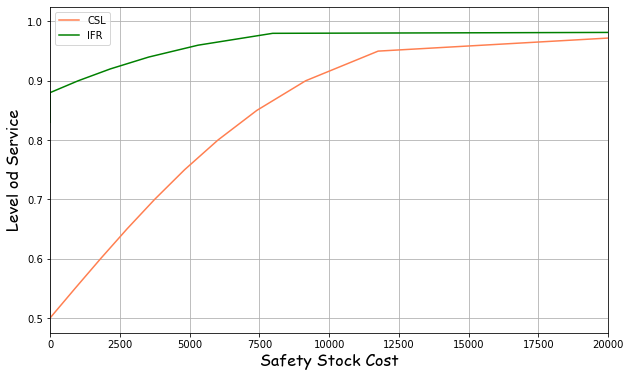

In [67]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=CSL_IFR_analysis,
             x='Cost_CSL',
             y='CSL',
             label='CSL',
             color='coral')

sns.lineplot(data=CSL_IFR_analysis,
             x='Cost_IFR',
             y='IFR',
             label='IFR',
             color='green')

plt.xlabel('Safety Stock Cost', fontsize=16, fontname='Comic Sans MS')

plt.ylabel('Level od Service', fontsize=16, fontname='Comic Sans MS')
plt.xlim(0, 20000)
plt.grid(which='major', axis='both')
# plt.savefig('CLS vs IFR.jpg', dpi=600)

### CSL/IFR vs LeadTime Analysis

In [68]:
LT_analysis1 = CSL_IFR_analysis.copy()
LT_analysis1['LeadTime'] = 2
LT_analysis1

,CSL,IFR,k1,k2,Cost_CSL,Cost_IFR,LeadTime
0,0.50,0.80,0.000000,0.000000,0.000000,0.000000,2
1,0.55,0.82,0.125661,0.000000,898.288195,0.000000,2
2,0.60,0.84,0.253347,0.000000,1811.047849,0.000000,2
3,0.65,0.86,0.385320,0.000000,2754.457396,0.000000,2
4,0.70,0.88,0.524401,0.000118,3748.668956,0.846387,2
5,0.75,0.90,0.674490,0.140997,4821.579549,1007.917642,2
6,0.80,0.92,0.841621,0.302199,6016.316374,2160.262930,2
7,0.85,0.94,1.036433,0.494685,7408.928058,3536.245085,2
8,0.90,0.96,1.281552,0.742125,9161.151549,5305.067110,2
9,0.95,0.98,1.644854,1.115970,11758.210717,7977.495763,2


In [69]:
LT_analysis2 = CSL_IFR_analysis.copy()
LT_analysis2['LeadTime'] = 1
LT_analysis2['Cost_CSL'] = ce * LT_analysis2.k1*(sigma * np.sqrt(1))
LT_analysis2['Cost_IFR'] = ce * LT_analysis2.k2 *(sigma * np.sqrt(1))
LT_analysis2

,CSL,IFR,k1,k2,Cost_CSL,Cost_IFR,LeadTime
0,0.50,0.80,0.000000,0.000000,0.000000,0.000000,1
1,0.55,0.82,0.125661,0.000000,635.185674,0.000000,1
2,0.60,0.84,0.253347,0.000000,1280.604215,0.000000,1
3,0.65,0.86,0.385320,0.000000,1947.695503,0.000000,1
4,0.70,0.88,0.524401,0.000118,2650.709239,0.598486,1
5,0.75,0.90,0.674490,0.140997,3409.371595,712.705400,1
6,0.80,0.92,0.841621,0.302199,4254.178106,1527.536567,1
7,0.85,0.94,1.036433,0.494685,5238.903271,2500.502879,1
8,0.90,0.96,1.281552,0.742125,6477.912384,3751.248928,1
9,0.95,0.98,1.644854,1.115970,8314.310533,5640.941351,1


In [70]:
LT_analysis3 = CSL_IFR_analysis.copy()
LT_analysis3['LeadTime'] = 4
LT_analysis3['Cost_CSL'] = ce * LT_analysis2.k1*(sigma * np.sqrt(4))
LT_analysis3['Cost_IFR'] = ce * LT_analysis2.k2 *(sigma * np.sqrt(4))
# LT_analysis3

In [71]:
LT_analysis4 = CSL_IFR_analysis.copy()
LT_analysis4['LeadTime'] = 6
LT_analysis4['Cost_CSL'] = ce * LT_analysis2.k1*(sigma * np.sqrt(6))
LT_analysis4['Cost_IFR'] = ce * LT_analysis2.k2 *(sigma * np.sqrt(6))
# LT_analysis4

In [75]:
LT_analysis = pd.concat([LT_analysis2,LT_analysis1,LT_analysis3,LT_analysis4])
LT_analysis.reset_index(inplace=True,drop=True)
LT_analysis

,CSL,IFR,k1,k2,Cost_CSL,Cost_IFR,LeadTime
0,0.50,0.80,0.000000,0.000000,0.000000,0.000000,1
1,0.55,0.82,0.125661,0.000000,635.185674,0.000000,1
2,0.60,0.84,0.253347,0.000000,1280.604215,0.000000,1
3,0.65,0.86,0.385320,0.000000,1947.695503,0.000000,1
4,0.70,0.88,0.524401,0.000118,2650.709239,0.598486,1
5,0.75,0.90,0.674490,0.140997,3409.371595,712.705400,1
6,0.80,0.92,0.841621,0.302199,4254.178106,1527.536567,1
7,0.85,0.94,1.036433,0.494685,5238.903271,2500.502879,1
8,0.90,0.96,1.281552,0.742125,6477.912384,3751.248928,1
9,0.95,0.98,1.644854,1.115970,8314.310533,5640.941351,1


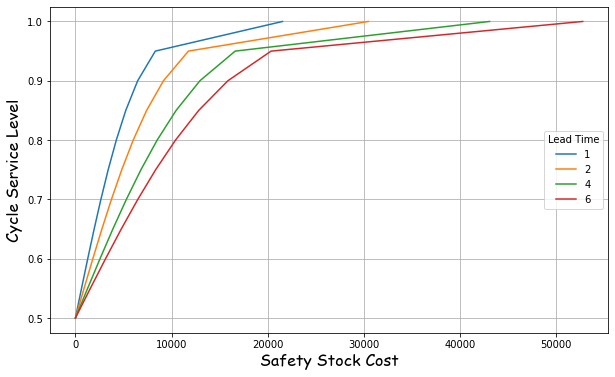

In [76]:
plt.figure(figsize=(10, 6))
LT_analysis['LeadTime'] = LT_analysis['LeadTime'].astype('category')

sns.lineplot(data=LT_analysis, x='Cost_CSL', y='CSL', hue='LeadTime')

plt.xlabel('Safety Stock Cost', fontsize=16, fontname='Comic Sans MS')
plt.ylabel('Cycle Service Level', fontsize=16, fontname='Comic Sans MS')
plt.legend(loc='right', title='Lead Time')
plt.grid(which='major', axis='both')
# plt.savefig('CSL_Lead.jpg', dpi=600)

(0.0, 30000.0)

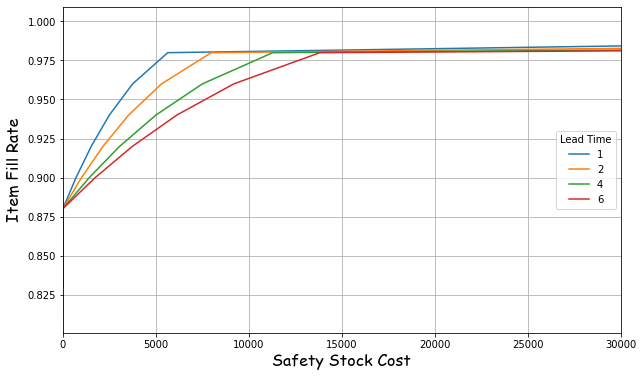

In [77]:
plt.figure(figsize=(10, 6))
LT_analysis['LeadTime'] = LT_analysis['LeadTime'].astype('category')

sns.lineplot(data=LT_analysis, x='Cost_IFR', y='IFR', hue='LeadTime')

plt.xlabel('Safety Stock Cost', fontsize=16, fontname='Comic Sans MS')
plt.ylabel('Item Fill Rate', fontsize=16, fontname='Comic Sans MS')
plt.legend(loc='right', title='Lead Time')
plt.grid(which='major', axis='both')
plt.xlim(0, 30000)
# plt.savefig('IFR_Lead.jpg', dpi=600)